# Gender Estimation

Also, we changed the Dataset used to be the [UTKFace Dataset](https://susanqq.github.io/UTKFace/),
which contains 23K images where each image is labelled with its gender, age and ethinicity.

For this second attemp we split the problem to make it easier to handle

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime

## Data processing

To process the data we will acomplish 3 tasks:

- This time we will read the image files as 3-channeled RGB images for training the model, so each array will have a shape of `[img_width, img_height, 3]`.

- Then parse the filename for each image.

- This is a binary classification of gender, an so, the gender need to be one-hot encoded.

This time we will make use of the Tensorflow's `tf.data.Dataset` method as it permits to process the data  taking advantage of parallel computing.

In [2]:
# Image size
MODEL_INPUT_IMAGE_SIZE = [128 ,128]

# Number of samples to take from dataset
NUM_SAMPLES = 20000

In [3]:
y1 = tf.constant([1., 0.], dtype='float32')
y2 = tf.constant([0., 1.], dtype='float32')

def parse_image(filename):

    # Read the image from the filename and resize it.
    image_raw = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, MODEL_INPUT_IMAGE_SIZE) / 255

    # Split the filename to get the age and the gender. Convert the age ( str ) and the gender ( str ) to dtype float32.
    parts = tf.strings.split( tf.strings.split( filename , '/' )[ 2 ] , '_' )

    # One-hot encode the label
    gender = tf.strings.to_number(parts[1])
    gender_onehot = (gender * y2) + ((1 - gender) * y1)

    return image , gender_onehot

2022-03-11 12:57:48.982919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 12:57:49.009898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 12:57:49.010038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 12:57:49.010553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
# List all the image files in the given directory.
list_ds = tf.data.Dataset.list_files( 'data/utkface23k/*' , shuffle=True )


# Map `parse_image` method to all filenames.
dataset = list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.take(NUM_SAMPLES)

Now we split the dataset, this time without using scikit-learn's train_test_split function, just for fun

In [5]:
# Fraction of the dataset to be used for testing.
TRAIN_TEST_SPLIT = 0.3

# Create train and test splits of the dataset.
num_examples_in_test_ds = int(dataset.cardinality().numpy() * TRAIN_TEST_SPLIT)

test_ds = dataset.take(num_examples_in_test_ds)
train_ds = dataset.skip(num_examples_in_test_ds)

print(f"Num examples in train ds {train_ds.cardinality()}")
print(f"Num examples in test ds {test_ds.cardinality()}")

Num examples in train ds 14000
Num examples in test ds 6000


## Building the model

This model performs a number of convolutions on a 4D tensor of images with shape [None, 200, 200, 3] in blocks determined by num_blocks.

Each block is a sequence of layers with this shape:

    Conv2D
    BatchNorm
    LeakyReLU

For each blocks we apply a number of filters for each layer defined by num_filters.

Dense layers are added to learn the features extracted by convolutional layers.

Finally, a Dropout layer is added to reduce overfitting by dropping a percentage of the convolutional learnt features, whose rate is decreased for each layer.

The last `Dense` layer applies the softmax activation function which yields a probability distribution for the two classes `male` and `female`

The network's output is a 2D tensor with shape `[ None, 2 ]`

In [6]:
leaky_relu_alpha = 0.2


def conv(x, num_filters, kernel_size=(3, 3), strides=1):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.HeNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(1e-5)
    )(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(x)
    
    return x


def dense(x, filters, dropout_rate):
    x = tf.keras.layers.Dense(
        filters,
        kernel_regularizer=tf.keras.regularizers.L2(0.1),
        bias_regularizer=tf.keras.regularizers.L2(0.1)
    )(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


num_blocks = 5
num_filters = [16, 32, 64, 128, 256, 256]
kernel_sizes = [3, 3, 3, 3, 3, 3]


inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [3])

x = inputs
for i in range(num_blocks):
    x = conv(x, num_filters=num_filters[i], kernel_size=kernel_sizes[i])
    x = tf.keras.layers.MaxPooling2D()(x)


x = tf.keras.layers.Flatten()(x)
conv_output = x

x = dense(conv_output, 256, 0.6)
x = dense(x, 64, 0.4)
x = dense(x, 32, 0.2)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)


model = tf.keras.models.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4608  

## Compiling the model

In [7]:
learning_rate = 0.0001
num_epochs = 10 
batch_size = 128
train_ds = train_ds.batch(batch_size).repeat(num_epochs)
test_ds = test_ds.batch(batch_size).repeat(num_epochs)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/gender.checkpoint/{epoch:02d}-{val_mae:.2f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='auto'
)


# Init TensorBoard Callback
logdir = os.path.join('tb_logs', 'model_gender')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)


model.compile( 
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics =['accuracy']
)

## Train

In [8]:
%load_ext tensorboard
%tensorboard --logdir tb_logs/

In [9]:
model.fit( 
    train_ds, 
    epochs=num_epochs,  
    validation_data=test_ds, callbacks=[ checkpoint_callback , tensorboard_callback , early_stopping_callback ]
)

Epoch 1/10


2022-03-11 12:57:55.340246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-11 12:57:57.068076: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1099/1100 [============================>.] - ETA: 0s - loss: 16.6303 - accuracy: 0.7889

2022-03-11 12:59:17.201019: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkpoints/gender.checkpoint/assets
1100/1100 [==============================] - 86s 73ms/step - loss: 16.6255 - accuracy: 0.7889 - val_loss: 2.6175 - val_accuracy: 0.8754
Epoch 2/10
1100/1100 [==============================] - 81s 72ms/step - loss: 1.2551 - accuracy: 0.8869 - val_loss: 0.5748 - val_accuracy: 0.9238
Epoch 3/10
1100/1100 [==============================] - 80s 72ms/step - loss: 0.4411 - accuracy: 0.9217 - val_loss: 0.3181 - val_accuracy: 0.9500
Epoch 4/10
1100/1100 [==============================] - 80s 72ms/step - loss: 0.3043 - accuracy: 0.9493 - val_loss: 0.2468 - val_accuracy: 0.9756
Epoch 5/10
1100/1100 [==============================] - 84s 75ms/step - loss: 0.2484 - accuracy: 0.9703 - val_loss: 0.2068 - val_accuracy: 0.9879
Epoch 6/10
1100/1100 [==============================] - 76s 68ms/step - loss: 0.2075 - accuracy: 0.9830 - val_loss: 0.1933 - val_accuracy: 0.9840
Epoch 7/10
1100/1100 [==============================] - 78s 70

## Model evaluation

In [10]:
test_images = []
test_labels = []


test_ds = test_ds.unbatch()
for image , label in test_ds.as_numpy_iterator():
    test_images.append(image)
    test_labels.append(label)


test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [12]:
p = model.evaluate(test_images, test_labels)

print(f"Loss: {p[0]}, accuracy: {p[1] * 100 }")

2022-03-11 13:12:16.900871: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11796480000 exceeds 10% of free system memory.
2022-03-11 13:12:41.187332: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11796480000 exceeds 10% of free system memory.


1875/1875 [==============================] - 9s 4ms/step - loss: 0.1175 - accuracy: 0.9958
Loss: 0.1174873486161232, accuracy: 99.58166480064392


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pred_y = model.predict(test_images)


report = classification_report(
    np.argmax(test_labels, axis=1),
    np.argmax(pred_y, axis=1),
    target_names=['male', 'female']
)

print(report)

2022-03-11 13:13:12.748970: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11796480000 exceeds 10% of free system memory.
2022-03-11 13:13:52.047879: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11796480000 exceeds 10% of free system memory.


              precision    recall  f1-score   support

        male       1.00      0.99      1.00     31227
      female       0.99      1.00      1.00     28773

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



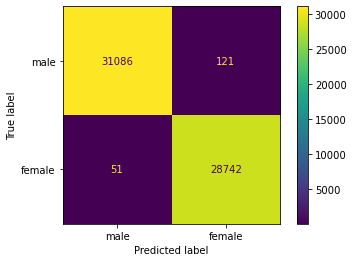

In [14]:
conf_matrix = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(pred_y, axis=1)
)


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['male', 'female'])
disp.plot() 


Save the Keras model to the local disk, so that we can resume training if needed.



In [14]:
model.save('../models/model_gender.h5') 


## 6) **Visualize the results**

We'll predict the age from some images taken from `test_ds` and plot them using `matplotlib`.


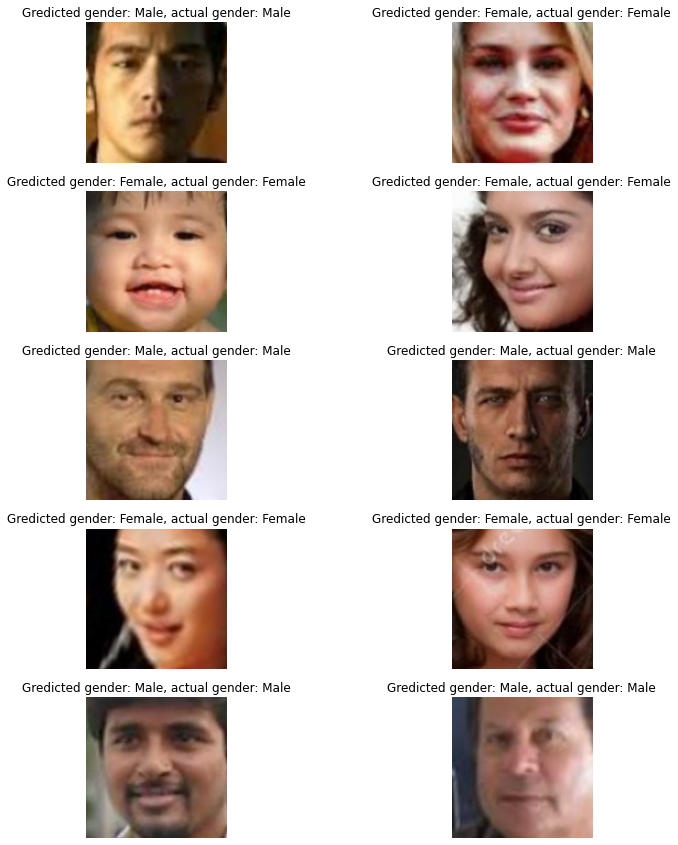

In [15]:
fig = plt.figure(figsize=(12, 15))
classes = ['Male', 'Female']
rows = 5
columns = 2

i = 1
for image, label in zip(test_images[0:10], test_labels[0:10]):
    # image = image.numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    label_ = classes[np.argmax(model.predict(np.expand_dims(image, 0)))]
    plt.axis('off')
    plt.title(f"Gredicted gender: {label_}, actual gender: {classes[np.argmax(label)]}")
    i += 1
